# Sentiment Analysis

In [1]:
import numpy as np
import pandas as pd
import plotly_express as px
import seaborn as sns

OHCO = ['album_id', 'song_num', 'stanza_num', 'line_num', 'token_num']
colors = 'YlGnBu'
salex_csv = '../../lexicons/salex_nrc.csv'
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()

## Read Data

In [2]:
LIB = pd.read_csv('../tables/LIB.csv', sep='|').set_index('album_id')
SONG_LIB = pd.read_csv('../tables/SONG_LIB', sep='|').set_index(['album_id', 'song_num'])
CORPUS = pd.read_csv('../tables/CORPUS.csv', sep='|').set_index(OHCO)
VOCAB = pd.read_csv('../tables/VOCAB.csv', sep='|').set_index('term_str')
BOW_SONG = pd.read_csv('../tables/BOW_SONG.csv', sep='|').set_index(['album_id', 'song_num', 'term_str'])
BOW_ALBUM = pd.read_csv('../tables/BOW_ALBUM.csv', sep='|').set_index(['album_id', 'term_str'])
TFIDF_ALBUM = pd.read_csv('../tables/TFIDF_ALBUM.csv', sep='|').set_index(OHCO[:1])
TFIDF_SONG = pd.read_csv('../tables/TFIDF_SONG.csv', sep='|').set_index(OHCO[:2])

In [3]:
VOCAB = VOCAB.drop_duplicates()

## Setup

In [4]:
SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]

In [5]:
SALEX

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,0,0,1,0,1,0,1,0,0,-1
abandonment,1,0,0,1,0,1,0,1,1,0,-1
abduction,0,0,0,1,0,1,0,1,1,0,-1
aberration,0,0,1,0,0,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
young,0,1,0,0,1,0,1,0,1,0,1
youth,1,1,0,1,1,0,1,0,1,0,1
zeal,0,1,0,0,1,0,1,0,1,1,1


## Combine `SALEX` with `VOCAB`

In [6]:
VOCAB_SENT = VOCAB.join(SALEX, how='inner')

In [7]:
VOCAB_SENT

,n,n_chars,p,i,max_pos,max_pos_group,stop,porter_stem,song_dfidf,album_dfidf,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,,,,,,,,,,,
abandon,2,7,0.000010,16.555301,NNP,NN,0,abandon,17.792665,10.951467,...,0,0,1,0,1,0,1,0,0,-1
abandoned,1,9,0.000005,17.555301,VBD,VB,0,abandon,9.896332,6.475733,...,0,0,1,0,1,0,1,0,0,-1
absence,6,7,0.000031,14.970338,NN,NN,0,absenc,37.872022,20.769027,...,0,0,1,0,1,0,1,0,0,-1
absentee,2,8,0.000010,16.555301,NN,NN,0,absente,9.896332,6.475733,...,0,0,0,0,1,0,1,0,0,-1
abundance,1,9,0.000005,17.555301,NN,NN,0,abund,9.896332,6.475733,...,1,1,0,1,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wretched,2,8,0.000010,16.555301,JJ,JJ,0,wretch,9.896332,6.475733,...,0,1,0,0,1,0,1,0,0,-1
yearning,2,8,0.000010,16.555301,NN,NN,0,yearn,17.792665,10.951467,...,1,0,0,1,1,1,0,0,1,0
yell,1,4,0.000005,17.555301,VB,VB,0,yell,9.896332,6.475733,...,0,0,1,0,1,0,0,1,0,-1


## Merge `VOCAB` with `BOW_ALBUM`

In [8]:
BOW_SENT_ALBUM = BOW_ALBUM.join(VOCAB_SENT[['max_pos', 'album_dfidf'] + emo_cols], on='term_str', rsuffix='_v').dropna()

In [9]:
BOW_SENT_ALBUM

n max_pos  album_dfidf  anger  anticipation  disgust  \
album_id term_str                                                           
0        afraid      2      JJ    44.899944    0.0           0.0      0.0   
         beautiful   2      JJ    43.076107    0.0           0.0      0.0   
         faith       1      NN    27.805867    0.0           1.0      0.0   
         favorite    2      JJ    33.179320    0.0           0.0      0.0   
         friendship  1      NN     6.475733    0.0           0.0      0.0   
...                 ..     ...          ...    ...           ...      ...   
88       weird       1      JJ    33.179320    0.0           0.0      1.0   
         wild        1      JJ    44.358640    0.0           0.0      0.0   
         winner      1     NNP    20.769027    0.0           1.0      0.0   
         worse       1     JJR    33.179320    0.0           0.0      0.0   
         youth       1      NN    29.752276    1.0           1.0      0.0   

                     fear  joy  sadness  surprise  trust  sentiment  
album_id term_str                                                    
0        afraid       1.0  0.0      0.0       0.0    0.0       -1.0  
         beautiful    0.0  1.0      0.0       0.0    0.0        1.0  
         faith        0.0  1.0      0.0       0.0    1.0        1.0  
         favorite     0.0  1.0      0.0       0.0    1.0        1.0  
         friendship   0.0  1.0      0.0       0.0    1.0        1.0  
...                   ...  ...      ...       ...    ...        ...  
88       weird        0.0  0.0      0.0       0.0    0.0       -1.0  
         wild         0.0  0.0      0.0       1.0    0.0       -1.0  
         winner       0.0  1.0      0.0       1.0    0.0        1.0  
         worse        1.0  0.0      1.0       0.0    0.0       -1.0  
         youth        1.0  1.0      0.0       1.0    0.0        1.0  

[5441 rows x 12 columns]

### Add Album TF-IDF to B for weighting emotions

In [10]:
tfidf = TFIDF_ALBUM.stack().to_frame()

In [11]:
tfidf.columns = ['tfidf']
tfidf.index = tfidf.index.rename(['album_id', 'term_str'])

In [12]:
BOW_SENT_ALBUM = BOW_SENT_ALBUM.join(tfidf, how='inner')

In [13]:
BOW_SENT_ALBUM.head()

n max_pos  album_dfidf  anger  anticipation  disgust  \
album_id term_str                                                           
0        afraid      2      JJ    44.899944    0.0           0.0      0.0   
         beautiful   2      JJ    43.076107    0.0           0.0      0.0   
         faith       1      NN    27.805867    0.0           1.0      0.0   
         favorite    2      JJ    33.179320    0.0           0.0      0.0   
         friendship  1      NN     6.475733    0.0           0.0      0.0   

                     fear  joy  sadness  surprise  trust  sentiment     tfidf  
album_id term_str                                                              
0        afraid       1.0  0.0      0.0       0.0    0.0       -1.0  0.108454  
         beautiful    0.0  1.0      0.0       0.0    0.0        1.0  0.119656  
         faith        0.0  1.0      0.0       0.0    1.0        1.0  0.096548  
         favorite     0.0  1.0      0.0       0.0    1.0        1.0  0.167572  
         friendship   0.0  1.0      0.0       0.0    1.0        1.0  0.179881

## Weight emotions by TFIDF

In [14]:
for col in emo_cols:
    BOW_SENT_ALBUM[col] = BOW_SENT_ALBUM[col] * BOW_SENT_ALBUM.tfidf

In [15]:
BOW_SENT_ALBUM.head()

n max_pos  album_dfidf  anger  anticipation  disgust  \
album_id term_str                                                           
0        afraid      2      JJ    44.899944    0.0      0.000000      0.0   
         beautiful   2      JJ    43.076107    0.0      0.000000      0.0   
         faith       1      NN    27.805867    0.0      0.096548      0.0   
         favorite    2      JJ    33.179320    0.0      0.000000      0.0   
         friendship  1      NN     6.475733    0.0      0.000000      0.0   

                         fear       joy  sadness  surprise     trust  \
album_id term_str                                                      
0        afraid      0.108454  0.000000      0.0       0.0  0.000000   
         beautiful   0.000000  0.119656      0.0       0.0  0.000000   
         faith       0.000000  0.096548      0.0       0.0  0.096548   
         favorite    0.000000  0.167572      0.0       0.0  0.167572   
         friendship  0.000000  0.179881      0.0       0.0  0.179881   

                     sentiment     tfidf  
album_id term_str                         
0        afraid      -0.108454  0.108454  
         beautiful    0.119656  0.119656  
         faith        0.096548  0.096548  
         favorite     0.167572  0.167572  
         friendship   0.179881  0.179881

## Compute Doc (`ALBUM`) sentiment 

In [16]:
ALBUM_SENT = BOW_SENT_ALBUM.groupby('album_id').agg({
    'anger':'mean',
    'anticipation':'mean',
    'disgust':'mean',
    'fear':'mean',
    'joy':'mean',
    'sadness':'mean',
    'surprise':'mean',
    'trust':'mean',
    'sentiment':'mean'
})

In [17]:
ALBUM_SENT

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment
album_id,,,,,,,,,
0,0.020018,0.046307,0.029055,0.052652,0.078762,0.051305,0.014813,0.034162,0.015823
1,0.029324,0.016176,0.027757,0.041690,0.029160,0.025601,0.013447,0.031395,-0.026267
2,0.016617,0.021864,0.007593,0.017183,0.029052,0.012295,0.009189,0.033763,0.011930
3,0.011425,0.011072,0.012779,0.016213,0.014134,0.017504,0.004888,0.016325,-0.030101
4,0.015838,0.009816,0.013306,0.062170,0.012721,0.073089,0.001620,0.023182,-0.060353
...,...,...,...,...,...,...,...,...,...
84,0.004495,0.004237,0.004292,0.008692,0.007992,0.008996,0.005163,0.007021,-0.003867
85,0.009014,0.008448,0.008399,0.012080,0.009030,0.015282,0.007121,0.010404,-0.008339
86,0.008974,0.011029,0.006773,0.016942,0.010613,0.022236,0.005707,0.009429,-0.012763


## Add `ALBUM_SENT` to `LIB`

In [18]:
LIB = LIB.join(ALBUM_SENT)

In [19]:
LIB['datelen'] = LIB.release_date.apply(lambda x: len(x))

In [20]:
LIB['year'] = LIB.release_date.apply(lambda x: x[:4])

In [21]:
LIB[LIB.datelen == 4]

,album_name,album_title,artist,source_file_path,song_regex,genres,release_date,label,mean_danceability,mean_energy,...,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment,datelen,year
album_id,,,,,,,,,,,,,,,,,,,,,
23,Forgiveness_Rock_Record,Forgiveness Rock Record,Broken Social Scene,../data/albums/Forgiveness_Rock_Record.txt,\[Trackname:\s[^\]]+\],"['alternative rock', 'baroque pop', 'canadian ...",2010,Arts & Crafts Productions Inc.,0.530154,0.604846,...,0.004636,0.009113,0.014493,0.008251,0.012199,0.004235,0.010143,-0.011373,4,2010
27,Grow_Up_And_Blow_Away,Grow Up And Blow Away,Metric,../data/albums/Grow_Up_And_Blow_Away.txt,\[Trackname:\s[^\]]+\],"['canadian indie', 'canadian rock', 'indie roc...",2007,Last Gang,0.606800,0.632500,...,0.014559,0.023334,0.023664,0.015234,0.016956,0.005901,0.012237,-0.015533,4,2007
42,Live_It_Out,Live It Out,Metric,../data/albums/Live_It_Out.txt,\[Trackname:\s[^\]]+\],"['canadian indie', 'canadian rock', 'indie roc...",2005,Last Gang,0.521000,0.811400,...,0.014171,0.017588,0.027316,0.015626,0.014493,0.007220,0.030673,-0.008450,4,2005
49,Masterpiece_(2023_Remaster),Masterpiece (2023 Remaster),Big Thief,../data/albums/Masterpiece_(2023_Remaster).txt,\[Trackname:\s[^\]]+\],"['art pop', 'brooklyn indie', 'chamber pop', '...",2016,4AD,0.395167,0.509225,...,0.008060,0.006705,0.016418,0.015089,0.011399,0.004542,0.013123,0.000850,4,2016
52,Morning_Better_Last!,Morning Better Last!,Dirty Projectors,../data/albums/Morning_Better_Last!.txt,\[Trackname:\s[^\]]+\],"['art pop', 'brooklyn indie', 'indie rock', 'i...",2003,States Rights Records,0.484684,0.341511,...,0.013918,0.012186,0.023365,0.020722,0.020159,0.011507,0.028757,0.002470,4,2003


### Manual date editing

In [22]:
LIB.loc[23, 'release_date'] = '2010-05-04'
LIB.loc[27, 'release_date'] = '2007-06-26'
LIB.loc[42, 'release_date'] = '2005-09-27'
LIB.loc[49, 'release_date'] = '2016-05-27'
LIB.loc[52, 'release_date'] = '2003-09-01'

### Convert `release_date` to datetime

In [23]:
LIB.release_date = LIB.release_date.astype('datetime64[ns]')

## Plot sentiment over time

#### Mean sentiment by year

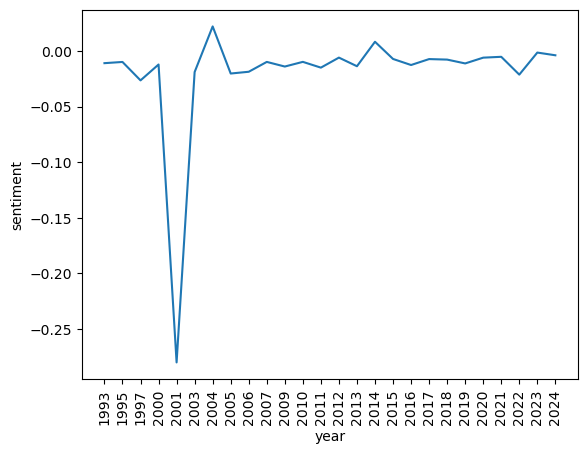

In [24]:
plot = sns.lineplot(data=LIB.groupby('year').agg({'sentiment':'mean'}), x='year', y='sentiment')
plot.tick_params(axis='x', rotation=90)

In [25]:
LIB[LIB.year == '2001']

,album_name,album_title,artist,source_file_path,song_regex,genres,release_date,label,mean_danceability,mean_energy,...,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment,datelen,year
album_id,,,,,,,,,,,,,,,,,,,,,
4,Amnesiac,Amnesiac,Radiohead,../data/albums/Amnesiac.txt,\[Trackname:\s[^\]]+\],"['alternative rock', 'art rock', 'melancholia'...",2001-03-12,XL Recordings,0.408500,0.495100,...,0.009816,0.013306,0.062170,0.012721,0.073089,0.00162,0.023182,-0.060353,10,2001
21,Feel_Good_Lost,Feel Good Lost,Broken Social Scene,../data/albums/Feel_Good_Lost.txt,\[Trackname:\s[^\]]+\],"['alternative rock', 'baroque pop', 'canadian ...",2001-03-06,Arts & Crafts Productions Inc.,0.485333,0.462667,...,0.000000,0.000000,0.499603,0.000000,0.499603,0.00000,0.000000,-0.499603,10,2001


In [26]:
LIB.loc[21].album_term_count

157

It looks like 2001 is a super sad year, but it turns out this is due to there only being two albums in my forpus from this year, and one is mostly instrumental, with two very short, very sad songs. This highlights sensitivity of sentiment analysis to document size.

## Possible Riff 1
Plot sentiment by artist. Who is the saddest??

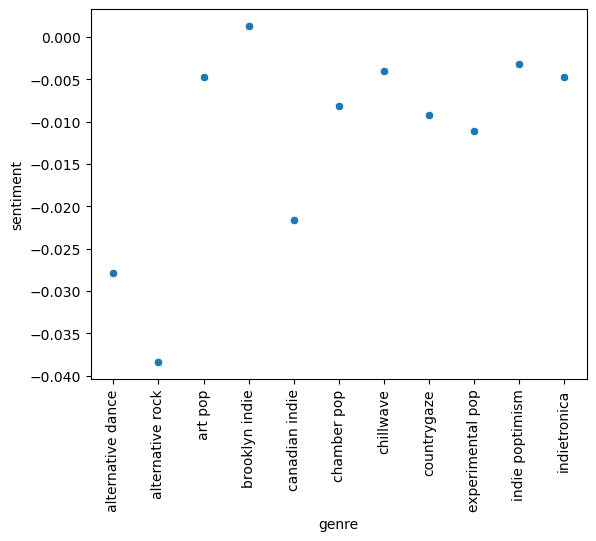

In [43]:
plot = sns.scatterplot(data=LIB.groupby('genre').agg({'sentiment':'mean'}), x='genre', y='sentiment')
plot.tick_params(axis='x', rotation=90)

## Possible Riff 2

* Graph sentiment by artist over albums
    * Do artists have sentiment arcs over albums?

Or

* Graph sentiment by song within album
    * Do albums have sentiment arcs over songs?

In [46]:
LIB

,album_name,album_title,artist,source_file_path,song_regex,genres,release_date,label,mean_danceability,mean_energy,...,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment,datelen,year
album_id,,,,,,,,,,,,,,,,,,,,,
0,45:33,45:33,LCD Soundsystem,../data/albums/45:33.txt,\[Trackname:\s[^\]]+\],"['alternative dance', 'alternative rock', 'art...",2007-11-12,Parlophone UK,0.625000,0.918000,...,0.046307,0.029055,0.052652,0.078762,0.051305,0.014813,0.034162,0.015823,10,2007
1,A_Moon_Shaped_Pool,A Moon Shaped Pool,Radiohead,../data/albums/A_Moon_Shaped_Pool.txt,\[Trackname:\s[^\]]+\],"['alternative rock', 'art rock', 'melancholia'...",2016-05-08,XL Recordings,0.429545,0.406455,...,0.016176,0.027757,0.041690,0.029160,0.025601,0.013447,0.031395,-0.026267,10,2016
2,Actor,Actor,St. Vincent,../data/albums/Actor.txt,\[Trackname:\s[^\]]+\],"['art pop', 'etherpop', 'indie rock', 'indietr...",2009-05-05,4AD,0.484091,0.548455,...,0.021864,0.007593,0.017183,0.029052,0.012295,0.009189,0.033763,0.011930,10,2009
3,Alligator,Alligator,The National,../data/albums/Alligator.txt,\[Trackname:\s[^\]]+\],"['chamber pop', 'indie folk', 'indie rock', 'i...",2005-04-11,Beggars Banquet,0.522154,0.740769,...,0.011072,0.012779,0.016213,0.014134,0.017504,0.004888,0.016325,-0.030101,10,2005
4,Amnesiac,Amnesiac,Radiohead,../data/albums/Amnesiac.txt,\[Trackname:\s[^\]]+\],"['alternative rock', 'art rock', 'melancholia'...",2001-03-12,XL Recordings,0.408500,0.495100,...,0.009816,0.013306,0.062170,0.012721,0.073089,0.001620,0.023182,-0.060353,10,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,Trouble_Will_Find_Me,Trouble Will Find Me,The National,../data/albums/Trouble_Will_Find_Me.txt,\[Trackname:\s[^\]]+\],"['chamber pop', 'indie folk', 'indie rock', 'i...",2013-05-20,4AD,0.487077,0.608769,...,0.004237,0.004292,0.008692,0.007992,0.008996,0.005163,0.007021,-0.003867,10,2013
85,Two_Hands,Two Hands,Big Thief,../data/albums/Two_Hands.txt,\[Trackname:\s[^\]]+\],"['art pop', 'brooklyn indie', 'chamber pop', '...",2019-10-11,4AD,0.502000,0.376720,...,0.008448,0.008399,0.012080,0.009030,0.015282,0.007121,0.010404,-0.008339,10,2019
86,U.F.O.F.,U.F.O.F.,Big Thief,../data/albums/U.F.O.F..txt,\[Trackname:\s[^\]]+\],"['art pop', 'brooklyn indie', 'chamber pop', '...",2019-05-03,4AD,0.554167,0.401250,...,0.011029,0.006773,0.016942,0.010613,0.022236,0.005707,0.009429,-0.012763,10,2019


## Save tables

In [27]:
VOCAB_SENT.to_csv('../tables/VOCAB_SENT.csv', sep='|')
BOW_SENT_ALBUM.to_csv('../tables/BOW_SENT_ALBUM.csv', sep='|')
ALBUM_SENT.to_csv('../tables/ALBUM_SENT.csv', sep='|')